## 包下载

In [ ]:
!wget https://www.dropbox.com/s/ipmoxnn344lw9up/Gao_LM-BFF-main.zip?dl=0 -O Gao_LM-BFF-main.zip
!unzip Gao_LM-BFF-main.zip

--2022-06-12 01:59:36--  https://www.dropbox.com/s/ipmoxnn344lw9up/Gao_LM-BFF-main.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ipmoxnn344lw9up/Gao_LM-BFF-main.zip [following]
--2022-06-12 01:59:36--  https://www.dropbox.com/s/raw/ipmoxnn344lw9up/Gao_LM-BFF-main.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc4fa7862f4eeea078383947d3b.dl.dropboxusercontent.com/cd/0/inline/BnDBTHJ0Sfhs4BKUJ1hyQgVXI1j4rJh_LQ_XlC4w6SFL-m_wOLmE71PHyExIej0r-f_Wkm0A1B1nqAazLNKA5UwKWuI4XJDLAkSudzQ6QAYG6Cdg0iaocpxVgruz-sizC8C45u4HymPKOpRs4v1ujzpdxIz6m2HgN3F5_jn3Fdrv_Q/file# [following]
--2022-06-12 01:59:36--  https://ucc4fa7862f4eeea078383947d3b.dl.dropboxusercontent.com/cd/0/inline/BnDBTHJ0Sfhs4BKUJ1hyQgVXI1j4rJh_LQ_XlC4

In [ ]:
!pip install -q -r requirements.txt

     |████████████████████████████████| 147 kB 15.4 MB/s 
     |████████████████████████████████| 178 kB 63.1 MB/s 
ERROR: Could not find a version that satisfies the requirement dataclasses==0.8 (from versions: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6)
ERROR: No matching distribution found for dataclasses==0.8


In [ ]:
!pip install transformers==3.4.0

import transformers
print(transformers.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-3.4.0-py3-none-any.whl (1.3 MB)
  Using cached tokenizers-0.9.2-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.19.4
    Uninstalling transformers-4.19.4:
      Successfully uninstalled transformers-4.19.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 2.2.0 requires transformers<5.0.0,>=4.6.0, but you have transformers 3.4.0 which is incompatible.


4.19.4


In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 5.9 MB/s 
     |████████████████████████████████| 4.2 MB 36.7 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 49.7 MB/s 
     |████████████████████████████████| 596 kB 64.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=d54983dde889cb44d92df39c7a22a4849df57cea90dd96c3aeb22212af41f853
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.2
    Uninstalling tokenizers-0.9.2:
      Successfull

# run

In [ ]:
"""Finetuning the library models for sequence classification on GLUE."""

import dataclasses
import logging
import os
import sys
from dataclasses import dataclass, field
from typing import Callable, Dict, Optional
import torch

import numpy as np

import transformers
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction
from transformers import GlueDataTrainingArguments as DataTrainingArguments
from transformers import HfArgumentParser, TrainingArguments, set_seed

from src.dataset import FewShotDataset
from src.models import BertForPromptFinetuning, RobertaForPromptFinetuning, resize_token_type_embeddings
from src.trainer import Trainer
from src.processors import processors_mapping, num_labels_mapping, output_modes_mapping, compute_metrics_mapping, bound_mapping

from filelock import FileLock
from datetime import datetime

from copy import deepcopy
from tqdm import tqdm
import json

logger = logging.getLogger(__name__)


@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """
    model_name_or_path: str = field(
        default='bert-base-uncased',
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
        default='bert-base-uncased',
         metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default='bert-base-uncased',
        metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default='bert-base-uncased', metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )
    # Few-shot type
    #   - finetune: standard fine-tuning
    #   - prompt: prompt-based fine-tuning
    #   - prompt-demo: prompt-based fine-tuning with demonstrations
    few_shot_type: str = field(
        default='prompt-demo',
        metadata={"help": "Few-shot learning model type. Choice: finetune, prompt, prompt-demo"}
    )

    # Only for BERT-type model
    random_segment: bool = field(
        default=False,
        metadata={"help": "Whether to reinitialize the token type embeddings (only for BERT)."}
    )

@dataclass
class DynamicDataTrainingArguments(DataTrainingArguments):
    """
    Arguments for dynamic training.
    """
    num_k: Optional[int] = field(
        default=16,
        metadata={"help": "Number of training instances per class"}
    )

    num_sample: Optional[int] = field(
        default=16,
        metadata={"help": "Number of samples (for inference) in fine-tuning with demonstrations"}
    )

    num_demo: Optional[int] = field(
        default=1,
        metadata={"help": "Number of demonstrations from each class"}
    )

    auto_demo: bool = field(
        default=True,
        metadata={"help": "Automatically generate template for using demonstrations"}
    )

    #自己添加的
    task_name:str = field(
        default='CoLA',
        metadata={"help": "任务形式"}
    )
    data_dir:str=field(
        default='data/k-shot/CoLA/16-13',
        metadata={"help": "数据集存放位置"}
    )














    # For prompting
    template: str = field(
        default='*cls**sent_0*_This_is*mask*.*sep+*',
        metadata={"help": "Template"}
    )

    mapping: str = field(
        default="{'0':'incorrect','1':'correct'}",
        metadata={"help": "Label word mapping"}
    )

    template_path: str = field(
        default=None,
        metadata={"help": "Path to a txt file that stores all the templates, one per line. Do not set this when prompt_path is used"}
    )

    mapping_path: str = field(
        default=None,
        metadata={"help": "Path to a txt file that stores all the label word mappings, one per line. Do not set this when prompt_path is used"}
    )

    prompt_path: str = field(
        default=None,
        metadata={"help": "Path to a txt file that stores all the prompts (templates and mappings), one per line"}
    )
 
    template_id: int = field(
        default=None,
        metadata={"help": "Template id if using template_path"}
    )

    mapping_id: int = field(
        default=None,
        metadata={"help": "Mapping id if using template_path"}
    )

    prompt_id: int = field(
        default=None,
        metadata={"help": "Prompt id if using prompt_path"}
    )

    top_n_template: int = field(
        default=None,
        metadata={"help": "Use top-n template in the template path"}
    )

    # For logging
    tag: str = field(
        default='',
        metadata={"help": "Set the tag and find the result easier in the log."}
    )

    # For filtering when using demonstrations
    demo_filter: bool = field(
        default=False,
        metadata={"help": "Only use similar instances in demonstrations"}
    )

    demo_filter_rate: float = field(
        default=0.5,
        metadata={"help": "Only use top-x\% similar instances in demonstrations"}
    )

    demo_filter_model: str = field(
        default=None,
        metadata={"help": "Model name for demonstration filter embeddings. Will load embeddings based on the model name."}
    )

    debug_mode: bool = field(
        default=False,
        metadata={"help": "Debug mode"}
    )

    # For max length
    double_demo: bool = field(
        default=False,
        metadata={"help": "Use double length for using demonstrations"}
    )

    first_sent_limit: int = field(
        default=None,
        metadata={"help": "Limit the length of the first sentence (i.e., sent_0)"}
    )

    other_sent_limit: int = field(
        default=None,
        metadata={"help": "Limit the length of sentences other than the first sentence"}
    )

    use_full_length: bool = field(
        default=None,
        metadata={"help": "Use the full length (512)"}
    )

    # GPT-3's in-context learning
    gpt3_in_context_head: bool = field(
        default=False,
        metadata={"help": "GPT-3's in-context learning (context at the beginning)"}
    )

    gpt3_in_context_tail: bool = field(
        default=False,
        metadata={"help": "GPT-3's in-context learning (context at the end)"}
    )

    gpt3_in_context_num: int = field(
        default=32,
        metadata={"help": "Number of context examples"}
    )

    truncate_head: bool = field(
        default=False,
        metadata={"help": "When exceeding the maximum length, truncate the head instead of the tail."}
    )

    # Do not set up the following fields. They are set up automatically.
    prompt: bool = field(
        default=False,
        metadata={"help": "Whether to use prompt-based fine-tuning"}
    )
    template_list: list = field(
        default=None,
        metadata={"help": "(DO NOT List of templates (only initialized after the program starts."}
    )


@dataclass
class DynamicTrainingArguments(TrainingArguments):

    output_dir:str=field(
        default='result/CoLA',
        metadata={'help':"输出数据存放位置"}
    )




    # For ensemble
    array_id: int = field(
        default=-1,
        metadata={"help": "Array ID (contains seed and hyper-paramter search) to idenfity the model"}
    )

    model_id: int = field(
        default=-1,
        metadata={"help": "Model ID (contains template information) to identify the model"}
    )

    save_logit: bool = field(
        default=False,
        metadata={"help": "Save test file logit with name $TASK-$MODEL_ID-$ARRAY_ID.npy"}
    )

    save_logit_dir: str = field(
        default=None,
        metadata={"help": "Where to save the prediction result"}
    )

    # Regularization
    fix_layers: int = field(
        default=0,
        metadata={"help": "Fix bottom-n layers when optimizing"}
    )

    # Training
    save_at_last: bool = field(
        default=False,
        metadata={"help": "Instead of saving the best (dev performance) checkpoint, save the last checkpoint"}
    )

    # Turn off train/test
    no_train: bool = field(
        default=False,
        metadata={"help": "No training"}
    )
    no_predict: bool = field(
        default=False,
        metadata={"help": "No test"}
    )


def main():
    parser = HfArgumentParser((ModelArguments, DynamicDataTrainingArguments, DynamicTrainingArguments))
    print(sys.argv)
    print(parser.parse_args_into_dataclasses())
    if len(sys.argv) == 2 and sys.argv[1].endswith(".json"):
        # If we pass only one argument to the script and it's the path to a json file,
        # let's parse it to get our arguments.
        model_args, data_args, training_args = parser.parse_json_file(json_file=os.path.abspath(sys.argv[1]))
    else:
        model_args, data_args, training_args = parser.parse_args_into_dataclasses()

    if 'prompt' in model_args.few_shot_type:
        data_args.prompt = True

    if training_args.no_train:
        training_args.do_train = False
    else:
        training_args.do_train=True
    # if training_args.no_predict:
    #     training_args.do_predict = False
    # else:
    training_args.do_predict=False

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN,
    )

    # Load prompt/template/mapping file
    if data_args.prompt:
        if data_args.prompt_path is not None:
            assert data_args.prompt_id is not None
            prompt_list = []
            with open(data_args.prompt_path) as f:
                for line in f:
                    line = line.strip()
                    template, mapping = line.split('\t')
                    prompt_list.append((template, mapping))

            data_args.template, data_args.mapping = prompt_list[data_args.prompt_id] 
            logger.info("Specify load the %d-th prompt: %s | %s" % (data_args.prompt_id, data_args.template, data_args.mapping))
        else:
            if data_args.template_path is not None:
                with open(data_args.template_path) as f:
                    data_args.template_list = []
                    for line in f:
                        line = line.strip()
                        if len(line) > 0:
                            data_args.template_list.append(line)

                # Load top-n templates
                if data_args.top_n_template is not None:
                    data_args.template_list = data_args.template_list[:data_args.top_n_template]
                logger.info("Load top-%d templates from %s" % (len(data_args.template_list), data_args.template_path))

                # ... or load i-th template
                if data_args.template_id is not None:
                    data_args.template = data_args.template_list[data_args.template_id]
                    data_args.template_list = None
                    logger.info("Specify load the %d-th template: %s" % (data_args.template_id, data_args.template))

            if data_args.mapping_path is not None:
                assert data_args.mapping_id is not None # Only can use one label word mapping
                with open(data_args.mapping_path) as f:
                    mapping_list = []
                    for line in f:
                        line = line.strip()
                        mapping_list.append(line)

                data_args.mapping = mapping_list[data_args.mapping_id]
                logger.info("Specify using the %d-th mapping: %s" % (data_args.mapping_id, data_args.mapping))

    # Check save path
    if (
        os.path.exists(training_args.output_dir)
        and os.listdir(training_args.output_dir)
        and training_args.do_train
        and not training_args.overwrite_output_dir
    ):
        raise ValueError(f"Output directory ({training_args.output_dir}) already exists.")

    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        training_args.local_rank,
        training_args.device,
        training_args.n_gpu,
        bool(training_args.local_rank != -1),
        training_args.fp16,
    )
    logger.info("Training/evaluation parameters %s", training_args)

    # Set seed
    set_seed(training_args.seed)

    try:
        num_labels = num_labels_mapping[data_args.task_name]
        output_mode = output_modes_mapping[data_args.task_name]
        logger.info("Task name: {}, number of labels: {}, output mode: {}".format(data_args.task_name, num_labels, output_mode))
    except KeyError:
        raise ValueError("Task not found: %s" % (data_args.task_name))

    # Automatically generate template for using demonstrations
    if data_args.auto_demo and model_args.few_shot_type == 'prompt-demo':
        # GPT-3's in-context learning
        if data_args.gpt3_in_context_head or data_args.gpt3_in_context_tail: 
            logger.info("Automatically convert the template to GPT-3's in-context learning.")
            assert data_args.template_list is None

            old_template = data_args.template
            new_template = old_template + ''
            old_template = old_template.replace('*cls*', '')
            # Single sentence or sentence pair?
            sent_num = 1
            if "_1" in old_template:
                sent_num = 2
            for instance_id in range(data_args.gpt3_in_context_num):
                sub_template = old_template + ''
                # Replace sent_id
                for sent_id in range(sent_num):
                    sub_template = sub_template.replace("_{}*".format(sent_id), "_{}*".format(sent_num + sent_num * instance_id + sent_id))
                # Replace mask
                sub_template = sub_template.replace("*mask*", "*labelx_{}*".format(instance_id))
                if data_args.gpt3_in_context_tail:
                    new_template = new_template + sub_template # Put context at the end
                else:
                    new_template = sub_template + new_template # Put context at the beginning
            logger.info("| {} => {}".format(data_args.template, new_template))
            data_args.template = new_template
        else:
            logger.info("Automatically convert the template to using demonstrations.")
            if data_args.template_list is not None:
                for i in range(len(data_args.template_list)):
                    old_template = data_args.template_list[i]
                    new_template = old_template + ''
                    old_template = old_template.replace('*cls*', '')
                    # Single sentence or sentence pair?
                    sent_num = 1
                    if "_1" in old_template:
                        sent_num = 2
                    for label_id in range(num_labels):
                        sub_template = old_template + ''
                        # Replace sent id
                        for sent_id in range(sent_num):
                            sub_template = sub_template.replace("_{}*".format(sent_id), "_{}*".format(sent_num + sent_num * label_id + sent_id))
                        # Replace mask
                        sub_template = sub_template.replace("*mask*", "*label_{}*".format(label_id))
                        new_template = new_template + sub_template
                    logger.info("| {} => {}".format(data_args.template_list[i], new_template))
                    data_args.template_list[i] = new_template
            else:
                old_template = data_args.template
                new_template = old_template + ''
                old_template = old_template.replace('*cls*', '')
                # Single sentence or sentence pair?
                sent_num = 1
                if "_1" in old_template:
                    sent_num = 2
                for label_id in range(num_labels):
                    sub_template = old_template + ''
                    # Replace sent id
                    for sent_id in range(sent_num):
                        sub_template = sub_template.replace("_{}".format(sent_id), "_{}".format(sent_num + sent_num * label_id + sent_id))
                    # Replace mask
                    sub_template = sub_template.replace("*mask*", "*label_{}*".format(label_id))
                    new_template = new_template + sub_template
                logger.info("| {} => {}".format(data_args.template, new_template))
                data_args.template = new_template

    # Create config
    config = AutoConfig.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        num_labels=num_labels,
        finetuning_task=data_args.task_name,
        cache_dir=model_args.cache_dir,
    )

    if 'prompt' in model_args.few_shot_type:
        if config.model_type == 'roberta':
            model_fn = RobertaForPromptFinetuning
        elif config.model_type == 'bert':
            model_fn = BertForPromptFinetuning
        else:
            raise NotImplementedError
    elif model_args.few_shot_type == 'finetune':
        model_fn = AutoModelForSequenceClassification
    else:
        raise NotImplementedError
    special_tokens = []

    # Create tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path,
        additional_special_tokens=special_tokens,
        cache_dir=model_args.cache_dir,
    )

    # Get our special datasets.
    train_dataset = (
        FewShotDataset(data_args, tokenizer=tokenizer, mode="train", use_demo=("demo" in model_args.few_shot_type))
    )
    eval_dataset = (
        FewShotDataset(data_args, tokenizer=tokenizer, mode="dev", use_demo=("demo" in model_args.few_shot_type))
        if training_args.do_eval
        else None
    )
    test_dataset = (
        FewShotDataset(data_args, tokenizer=tokenizer, mode="test", use_demo=("demo" in model_args.few_shot_type))
        if training_args.do_predict
        else None
    )

    set_seed(training_args.seed)

    model = model_fn.from_pretrained(
        model_args.model_name_or_path,
        from_tf=bool(".ckpt" in model_args.model_name_or_path),
        config=config,
        cache_dir=model_args.cache_dir,
    )

    # For BERT, increase the size of the segment (token type) embeddings
    if config.model_type == 'bert':
        model.resize_token_embeddings(len(tokenizer))
        resize_token_type_embeddings(model, new_num_types=10, random_segment=model_args.random_segment)

    # Pass dataset and argument information to the model
    if data_args.prompt:
        model.label_word_list = torch.tensor(train_dataset.label_word_list).long().cuda()
        # model.label_word_list = torch.tensor(train_dataset.label_word_list).long()
    if output_modes_mapping[data_args.task_name] == 'regression':
        # lower / upper bounds
        model.lb, model.ub = bound_mapping[data_args.task_name]
    model.model_args = model_args
    model.data_args = data_args
    model.tokenizer = tokenizer

    # Build metric
    def build_compute_metrics_fn(task_name: str) -> Callable[[EvalPrediction], Dict]:
        def compute_metrics_fn(p: EvalPrediction):
            # Note: the eval dataloader is sequential, so the examples are in order.
            # We average the logits over each sample for using demonstrations.
            predictions = p.predictions
            num_logits = predictions.shape[-1]
            logits = predictions.reshape([eval_dataset.num_sample, -1, num_logits])
            logits = logits.mean(axis=0)
            
            if num_logits == 1:
                preds = np.squeeze(logits)
            else:
                preds = np.argmax(logits, axis=1)

            # Just for sanity, assert label ids are the same.
            label_ids = p.label_ids.reshape([eval_dataset.num_sample, -1])
            label_ids_avg = label_ids.mean(axis=0)
            label_ids_avg = label_ids_avg.astype(p.label_ids.dtype)
            assert (label_ids_avg - label_ids[0]).mean() < 1e-2
            label_ids = label_ids[0]

            return compute_metrics_mapping[task_name](task_name, preds, label_ids)

        return compute_metrics_fn
    
    # Initialize our Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=build_compute_metrics_fn(data_args.task_name)
    )

    # Training
    if training_args.do_train:
        trainer.train(model_path=model_args.model_name_or_path if os.path.isdir(model_args.model_name_or_path) else None)
        # Use the early stop, so do not save the model in the end (unless specify save_at_last)
        if training_args.save_at_last:
            trainer.save_model(training_args.output_dir)
 
        if trainer.is_world_master():
            tokenizer.save_pretrained(training_args.output_dir)
            torch.save(model_args, os.path.join(training_args.output_dir, "model_args.bin"))
            torch.save(data_args, os.path.join(training_args.output_dir, "data_args.bin"))
        
        # Reload the best checkpoint (for eval)
        model = model_fn.from_pretrained(training_args.output_dir)
        model = model.to(training_args.device)
        trainer.model = model
        if data_args.prompt:
            model.label_word_list = torch.tensor(train_dataset.label_word_list).long().cuda()
            # model.label_word_list = torch.tensor(train_dataset.label_word_list).long()
        if output_modes_mapping[data_args.task_name] == 'regression':
            # lower / upper bounds
            model.lb, model.ub = bound_mapping[data_args.task_name]
        model.model_args = model_args
        model.data_args = data_args
        model.tokenizer = tokenizer

    # Evaluation
    final_result = {
        'time': str(datetime.today()),
    }

    eval_results = {}
    if training_args.do_eval:
        logger.info("*** Validate ***")

        eval_datasets = [eval_dataset]

        for eval_dataset in eval_datasets:
            trainer.compute_metrics = build_compute_metrics_fn(eval_dataset.args.task_name)
            output = trainer.evaluate(eval_dataset=eval_dataset)
            eval_result = output.metrics 

            output_eval_file = os.path.join(
                training_args.output_dir, f"eval_results_{eval_dataset.args.task_name}.txt"
            )
            if trainer.is_world_master():
                with open(output_eval_file, "w") as writer:
                    logger.info("***** Eval results {} *****".format(eval_dataset.args.task_name))
                    for key, value in eval_result.items():
                        logger.info("  %s = %s", key, value)
                        writer.write("%s = %s\n" % (key, value))
                        final_result[eval_dataset.args.task_name + '_dev_' + key] = value
            eval_results.update(eval_result)

    test_results = {}
    if training_args.do_predict:
        logging.info("*** Test ***")
        test_datasets = [test_dataset]
        if data_args.task_name == "mnli":
            mnli_mm_data_args = dataclasses.replace(data_args, task_name="mnli-mm")
            test_datasets.append(
                FewShotDataset(mnli_mm_data_args, tokenizer=tokenizer, mode="test", use_demo=('demo' in model_args.few_shot_type))
            )

        for test_dataset in test_datasets:
            trainer.compute_metrics = build_compute_metrics_fn(test_dataset.args.task_name)
            output = trainer.evaluate(eval_dataset=test_dataset)
            test_result = output.metrics

            output_test_file = os.path.join(
                training_args.output_dir, f"test_results_{test_dataset.args.task_name}.txt"
            )
            if trainer.is_world_master():
                with open(output_test_file, "w") as writer:
                    logger.info("***** Test results {} *****".format(test_dataset.args.task_name))
                    for key, value in test_result.items():
                        logger.info("  %s = %s", key, value)
                        writer.write("%s = %s\n" % (key, value))
                        final_result[test_dataset.args.task_name + '_test_' + key] = value

                if training_args.save_logit:
                    predictions = output.predictions
                    num_logits = predictions.shape[-1]
                    logits = predictions.reshape([test_dataset.num_sample, -1, num_logits]).mean(axis=0)
                    np.save(os.path.join(training_args.save_logit_dir, "{}-{}-{}.npy".format(test_dataset.task_name, training_args.model_id, training_args.array_id)), logits)

            test_results.update(test_result)

    with FileLock('log.lock'):
        with open('log', 'a') as f:
            final_result.update(vars(model_args))
            final_result.update(vars(training_args))
            final_result.update(vars(data_args))
            if 'evaluation_strategy' in final_result:
                final_result.pop('evaluation_strategy')
            f.write(str(final_result) + '\n')
    
    return eval_results

if __name__ == "__main__":
    main()


['/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-10c279eb-e84a-41c0-9644-705d818a7b1e.json']


ValueError: ignored

# 自动生成template

In [ ]:
import transformers
from transformers import T5ForConditionalGeneration, T5Tokenizer
import argparse
import torch
import os
from tqdm import tqdm
import json
import argparse
import pandas as pd

def get_text(template, input_text_tuple, label, tokenizer, mapping):
    def enc(text):
        return tokenizer.encode(text, add_special_tokens=False)
    special_token_mapping = {'cls': tokenizer.cls_token_id, 'mask': tokenizer.mask_token_id, 'sep': tokenizer.sep_token_id, 'sep+': tokenizer.sep_token_id}
    for i in range(10):
        special_token_mapping["<extra_id_%d>" % (i)] = tokenizer._convert_token_to_id("<extra_id_%d>" % (i))
    template_list = template.split('*')
    input_ids = []
    for part in template_list:
        new_tokens = []
        if part in special_token_mapping:
            if part == 'cls' and 'T5' in type(tokenizer).__name__:
                # T5 does not have cls token
                continue
            new_tokens.append(special_token_mapping[part])
        elif part[:5] == 'label':
            new_tokens += enc(' ' + mapping[label])
        elif part[:5] == 'sent_':
            sent_id = int(part.split('_')[1])
            new_tokens += enc(input_text_tuple[sent_id])
        elif part[:6] == '+sent_':
            sent_id = int(part.split('_')[1])
            new_tokens += enc(' ' + input_text_tuple[sent_id]) # add space
        elif part[:6] == 'sent-_':
            # Delete the last token
            sent_id = int(part.split('_')[1])
            new_tokens += enc(input_text_tuple[sent_id][:-1])
        elif part[:7] == '+sentl_':
            # Lower case the first token
            sent_id = int(part.split('_')[1])
            text = input_text_tuple[sent_id]
            text = text[:1].lower() + text[1:]
            new_tokens += enc(' ' + text)
        elif part[:7] == '+sentu_':
            # Upper case the first token
            sent_id = int(part.split('_')[1])
            text = input_text_tuple[sent_id]
            text = text[:1].upper() + text[1:]
            new_tokens += enc(' ' + text)
        elif part[:6] == 'sentl_':
            # Lower case the first token
            sent_id = int(part.split('_')[1])
            text = input_text_tuple[sent_id]
            text = text[:1].lower() + text[1:]
            new_tokens += enc(text)
        elif part[:6] == 'sentu_':
            # Lower case the first token
            sent_id = int(part.split('_')[1])
            text = input_text_tuple[sent_id]
            text = text[:1].upper() + text[1:]
            new_tokens += enc(text)
        elif part[:7] == 'sentl-_':
            # Lower case the first token
            sent_id = int(part.split('_')[1])
            text = input_text_tuple[sent_id]
            text = text[:1].lower() + text[1:]
            new_tokens += enc(text[:-1])
        else:
            part = part.replace('_', ' ') # there cannot be space in command, so use '_' to replace space
            # handle special case when t5 tokenizer might add an extra space
            if len(part) == 1:
                new_tokens.append(tokenizer._convert_token_to_id(part))
            else:
                new_tokens += enc(part)

        input_ids += new_tokens
    return input_ids

def generate(dataset, template, model, tokenizer, target_number, mapping, beam, label=None, length_limit=None, truncate=None):
    """
    Generate templates based on given inputs

    label: Only use instances with this label (deprecated)
    length_limit: At least generate content as long as length_limit (deprecated)
    """
    input_texts = []
    input_tensors = []
    max_length = 0

    # Process the inputs
    for item in dataset:
        if label is None or item['label'] == label:
            input_text = get_text(template, item['text'], item['label'], tokenizer, mapping)
            if truncate is not None:
                if truncate == 'head':
                    input_text = input_text[-256:]
                elif truncate == 'tail':
                    input_text = input_text[:256]
                else:
                    raise NotImplementedError
            input_ids = torch.tensor(input_text).long()
            max_length = max(max_length, input_ids.size(-1))
            input_tensors.append(input_ids)

    # Concatenate inputs as a batch
    input_ids = torch.zeros((len(input_tensors), max_length)).long()
    attention_mask = torch.zeros((len(input_tensors), max_length)).long()
    for i in range(len(input_tensors)):
        input_ids[i, :input_tensors[i].size(-1)] = input_tensors[i]
        attention_mask[i, :input_tensors[i].size(-1)] = 1

    # Print some examples
    print('####### example #######')
    print(tokenizer.decode(input_ids[0]))
    print(tokenizer.decode(input_ids[1]))
    print(tokenizer.decode(input_ids[2]))
    print('####### example #######\n')

    input_ids = input_ids.cuda()
    attention_mask = attention_mask.cuda()
    assert len(input_tensors) > 0

    # Maximum generate content length
    max_length = 20

    start_mask = tokenizer._convert_token_to_id('<extra_id_0>')
    ori_decoder_input_ids = torch.zeros((input_ids.size(0), max_length)).long()
    ori_decoder_input_ids[..., 0] = model.config.decoder_start_token_id

    # decoder_input_ids: decoder inputs for next regressive generation
    # ll: log likelihood
    # output_id: which part of generated contents we are at
    # output: generated content so far
    # last_length (deprecated): how long we have generated for this part
    current_output = [{'decoder_input_ids': ori_decoder_input_ids, 'll': 0, 'output_id': 1, 'output': [], 'last_length': -1}]
    for i in tqdm(range(max_length - 2)):
        new_current_output = []
        for item in current_output:
            if item['output_id'] > target_number:
                # Enough contents
                new_current_output.append(item)
                continue
            decoder_input_ids = item['decoder_input_ids']

            # Forward
            batch_size = 32
            # batch_size=12
            turn = input_ids.size(0) // batch_size
            if input_ids.size(0) % batch_size != 0:
                turn += 1
            aggr_output = []
            for t in range(turn):
                start = t * batch_size
                end = min((t + 1) * batch_size, input_ids.size(0))

                with torch.no_grad():
                    aggr_output.append(model(input_ids[start:end], attention_mask=attention_mask[start:end], decoder_input_ids=decoder_input_ids.cuda()[start:end])[0])
            aggr_output = torch.cat(aggr_output, 0)

            # Gather results across all input sentences, and sort generated tokens by log likelihood
            aggr_output = aggr_output.mean(0)
            log_denominator = torch.logsumexp(aggr_output[i], -1).item()
            ids = list(range(model.config.vocab_size))
            ids.sort(key=lambda x: aggr_output[i][x].item(), reverse=True)
            ids = ids[:beam+3]
            
            for word_id in ids:
                output_id = item['output_id']

                if word_id == start_mask - output_id or word_id == tokenizer._convert_token_to_id('</s>'):
                    # Finish one part
                    if length_limit is not None and item['last_length'] < length_limit[output_id - 1]:
                        check = False
                    else:
                        check = True
                    output_id += 1
                    last_length = 0
                else:
                    last_length = item['last_length'] + 1
                    check = True

                output_text = item['output'] + [word_id]
                ll = item['ll'] + aggr_output[i][word_id] - log_denominator
                new_decoder_input_ids = decoder_input_ids.new_zeros(decoder_input_ids.size())
                new_decoder_input_ids[:] = decoder_input_ids
                new_decoder_input_ids[..., i + 1] = word_id

                # Forbid single space token, "....", and ".........."
                if word_id in [3, 19794, 22354]:
                    check = False

                # Forbid continuous "."
                if len(output_text) > 1 and output_text[-2] == 5 and output_text[-1] == 5:
                    check = False

                if check:
                    # Add new results to beam search pool
                    new_item = {'decoder_input_ids': new_decoder_input_ids, 'll': ll, 'output_id': output_id, 'output': output_text, 'last_length': last_length}
                    new_current_output.append(new_item)

        if len(new_current_output) == 0:
            break

        new_current_output.sort(key=lambda x: x['ll'], reverse=True)
        new_current_output = new_current_output[:beam]
        current_output = new_current_output

    result = []
    print("####### generated results #######")
    for item in current_output:
        generate_text = ''
        for token in item['output']:
            generate_text += tokenizer._convert_id_to_token(token)
        print('--------------')
        print('score:', item['ll'].item())
        print('generated ids', item['output'])
        print('generated text', generate_text)
        result.append(generate_text)
    print("####### generated results #######\n")

    return result

def load_dataset(task, data_dir):
    if task in ["MNLI", "MRPC", "QNLI", "QQP", "RTE", "SNLI", "SST-2", "STS-B", "WNLI", "CoLA"]:
        lines = open(os.path.join(data_dir, 'train.tsv')).readlines()
        if task != 'CoLA':
            lines = lines[1:]

        dataset = []
        for line in lines:
            line = line.strip().split('\t')
            if task == 'CoLA':
                dataset.append({'label': line[1], 'text': [line[-1]]})
            elif task == 'MNLI':
                dataset.append({'label': line[-1], 'text': [line[8], line[9]]})
            elif task == 'MRPC':
                dataset.append({'label': line[0], 'text': [line[-2], line[-1]]})
            elif task == 'QNLI':
                dataset.append({'label': line[-1], 'text': [line[1], line[2]]})
            elif task == 'QQP':
                dataset.append({'label': line[-1], 'text': [line[3], line[4]]})
            elif task == 'RTE':
                dataset.append({'label': line[-1], 'text': [line[1], line[2]]})
            elif task == 'SNLI':
                dataset.append({'label': line[-1], 'text': [line[7], line[8]]})
            elif task == 'SST-2':
                dataset.append({'label': line[-1], 'text': [line[0]]})
            elif task == 'STS-B':
                dataset.append({'label': '0' if float(line[-1]) < 2.5 else '1', 'text': [line[-3], line[-2]]})
            elif task == 'WNLI':
                dataset.append({'label': line[-1], 'text': [line[1], line[2]]})
            else:
                raise NotImplementedError
    else:
        lines = pd.read_csv(os.path.join(data_dir, 'train.csv')).values.tolist()
        dataset = []
        for line in lines:
            dataset.append({'label': line[0], 'text': [line[1]]})

    return dataset

def search_template(model, tokenizer, task_name, k, seed, beam, output_dir, data_dir):
    print('#', task_name, k, seed, beam)
    dataset_path = os.path.join(data_dir, task_name, "{}-{}".format(k, seed))
    dataset = load_dataset(task_name, dataset_path)
    print('|', 'dataset examples')
    print('|', dataset[0])
    print('|', dataset[-1])
    print()
    
    # Manual label word mappings
    map_of_mapping = {
        'SST-2': {'0':'terrible','1':'great'},
        'sst-5': {0:'terrible',1:'bad',2:'okay',3:'good',4:'great'},
        'mr': {0:'terrible',1:'great'},
        'cr': {0:'terrible',1:'great'},
        'subj': {0:'subjective',1:'objective'},
        'trec': {0:'Description',1:'Entity',2:'Expression',3:'Human',4:'Location',5:'Number'},
        'mpqa': {0:'terrible',1:'great'},
        'CoLA': {'0':'incorrect','1':'correct'},
        'MRPC': {'0':'No','1':'Yes'},
        'QQP': {'0':'No','1':'Yes'},
        'STS-B': {'0':'No','1':'Yes'},
        'MNLI': {'contradiction':'No','entailment':'Yes','neutral':'Maybe'},
        'SNLI': {'contradiction':'No','entailment':'Yes','neutral':'Maybe'},
        'QNLI': {'not_entailment':'No','entailment':'Yes'},
        'RTE': {'not_entailment':'No','entailment':'Yes'}
    }

    mapping = map_of_mapping[task_name]
    print('|', 'mapping')
    print('|', mapping)

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, task_name), exist_ok=True)
    f = open(os.path.join(output_dir, task_name, "{}-{}.txt".format(k, seed)), 'w')

    if task_name in ['SST-2', 'sst-5', 'mr', 'cr', 'subj', 'trec', 'CoLA', 'mpqa']:
        # Single sentence tasks
        # We take two kinds of templates: put [MASK] at the beginning or the end
        template = "*cls**sentu_0**<extra_id_0>**label**<extra_id_1>**sep+*"
        generate_text = generate(dataset, template, model, tokenizer, target_number=2, mapping=mapping, beam=beam, label=None, truncate='head')[:beam//2]

        print("####### generated templates #######")
        for text in generate_text:
            # Transform T5 outputs to our template format
            text = text.replace('<extra_id_0>', '*cls**sent_0*')
            text = text.replace('<extra_id_1>', '*mask*')
            text = text.replace('<extra_id_2>', '*sep+*')
            text = text.replace('</s>', '*sep+*')
            text = text.replace('▁', '_')
            print(text)
            f.write(text + '\n')
        print("####### generated templates #######\n")

        template = "*cls*.*<extra_id_0>**label**<extra_id_1>**+sentu_0**sep+*"
        generate_text = generate(dataset, template, model, tokenizer, target_number=2, mapping=mapping, beam=beam, label=None, truncate='tail')[:beam//2]
        print("####### generated templates #######")
        for text in generate_text:
            # Transform T5 outputs to our template format
            text = text.replace('<extra_id_0>', '*cls*')
            text = text.replace('<extra_id_1>', '*mask*')
            text = text.replace('<extra_id_2>', '*+sent_0**sep+*')
            text = text.replace('</s>', '*+sent_0**sep+*')
            text = text.replace('▁', '_')
            print(text)
            f.write(text + '\n')
        print("####### generated templates #######\n")

    elif task_name in ['MRPC', 'QQP', 'STS-B', 'MNLI', 'SNLI', 'QNLI', 'RTE']:
        # Sentence pair tasks
        # We always put [MASK] between the two sentences
        template = "*cls**sent-_0**<extra_id_0>**label**<extra_id_1>**+sentl_1**sep+*"
        generate_text = generate(dataset, template, model, tokenizer, target_number=2, mapping=mapping, beam=beam, label=None)
        print("####### generated templates #######")
        for text in generate_text:
            # Transform T5 outputs to our template format
            text = text.replace('<extra_id_0>', '*cls**sent-_0*')
            text = text.replace('<extra_id_1>', '*mask*')
            text = text.replace('<extra_id_2>', '*+sentl_1**sep+*')
            text = text.replace('</s>', '*+sentl_1**sep+*')
            text = text.replace('▁', '_')
            print(text)
            f.write(text + '\n')
        print("####### generated templates #######\n")
    else:
        raise NotImplementedError



In [ ]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--t5_model', type=str, default='t5-base', help='T5 pre-trained model')
    parser.add_argument('--seed', type=int, nargs='+', default=[42, 13, 21, 100, 87], help="Data split seeds")
    parser.add_argument('--task_name',type=str,default=['CoLA'])
    # parser.add_argument('--task_name', type=str, nargs='+', default=['SST-2', 'sst-5', 'mr', 'cr', 'subj', 'trec', 'CoLA', 'MRPC', 'QQP', 'STS-B', 'MNLI', 'SNLI', 'QNLI', 'RTE'], help="Task names")
    parser.add_argument('--output_dir', type=str, default='Output directory')

    parser.add_argument('--data_dir', type=str, default="data/k-shot", help="Data directory")
    parser.add_argument('--beam', type=int, default=100, help="Beam search width")
    parser.add_argument('--k', type=int, default=16, help="Number of training instances per label")
 
    args = parser.parse_args(args=[])

    model = T5ForConditionalGeneration.from_pretrained(args.t5_model)
    tokenizer = T5Tokenizer.from_pretrained(args.t5_model)
    tokenizer.sep_token = '</s>'

    model = model.cuda()
    model.eval()

    for task_name in args.task_name:
        for seed in args.seed:
            search_template(model=model, tokenizer=tokenizer, task_name=task_name, k=args.k, seed=seed, beam=args.beam, output_dir=args.output_dir, data_dir=args.data_dir)

if __name__ == '__main__':
    main()

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


# CoLA 16 42 100
| dataset examples
| {'label': '1', 'text': ['Reports which the government prescribes the height of the lettering on the covers of are invariably boring.']}
| {'label': '0', 'text': ['Susan found any book she had been looking for at Borders.']}

| mapping
| {'0': 'incorrect', '1': 'correct'}
####### example #######
Reports which the government prescribes the height of the lettering on the covers of are invariably boring.<extra_id_0> correct<extra_id_1> </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
The reporters expected that the principal would fire some teacher.<extra_id_0> correct<extra_id_1> </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
These lines were written by one of Korea's most famous poets.<extra_id_0> correct<extra_id_1> </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
####### example #######



100%|██████████| 18/18 [04:48<00:00, 16.05s/it]


####### generated results #######
--------------
score: -4.006314277648926
generated ids [32099, 100, 19, 32098, 5, 1]
generated text <extra_id_0>▁This▁is<extra_id_1>.</s>
--------------
score: -4.639911651611328
generated ids [32099, 94, 19, 32098, 5, 1]
generated text <extra_id_0>▁It▁is<extra_id_1>.</s>
--------------
score: -4.757698059082031
generated ids [32099, 27, 7, 48, 32098, 58, 1]
generated text <extra_id_0>▁Is▁this<extra_id_1>?</s>
--------------
score: -4.885978698730469
generated ids [32099, 27, 7, 24, 32098, 58, 1]
generated text <extra_id_0>▁Is▁that<extra_id_1>?</s>
--------------
score: -4.9694414138793945
generated ids [32099, 466, 19, 32098, 5, 1]
generated text <extra_id_0>▁That▁is<extra_id_1>.</s>
--------------
score: -5.1420087814331055
generated ids [32099, 27, 183, 32098, 5, 1]
generated text <extra_id_0>▁I▁am<extra_id_1>.</s>
--------------
score: -5.1843156814575195
generated ids [32099, 94, 47, 32098, 5, 1]
generated text <extra_id_0>▁It▁was<extra_id_1>.</s>

100%|██████████| 18/18 [04:51<00:00, 16.19s/it]


####### generated results #######
--------------
score: -4.108630180358887
generated ids [32099, 100, 19, 32098, 5, 32097]
generated text <extra_id_0>▁This▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.16633939743042
generated ids [32099, 94, 19, 32098, 5, 32097]
generated text <extra_id_0>▁It▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.298387050628662
generated ids [32099, 466, 19, 32098, 5, 32097]
generated text <extra_id_0>▁That▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.543493270874023
generated ids [32099, 94, 47, 32098, 5, 32097]
generated text <extra_id_0>▁It▁was<extra_id_1>.<extra_id_2>
--------------
score: -5.698448181152344
generated ids [32099, 148, 33, 32098, 5, 32097]
generated text <extra_id_0>▁You▁are<extra_id_1>.<extra_id_2>
--------------
score: -5.795910835266113
generated ids [32099, 100, 47, 32098, 5, 32097]
generated text <extra_id_0>▁This▁was<extra_id_1>.<extra_id_2>
--------------
score: -5.857254505157471
generated ids [32099, 466, 47,

100%|██████████| 18/18 [04:51<00:00, 16.19s/it]


####### generated results #######
--------------
score: -3.7242050170898438
generated ids [32099, 100, 19, 32098, 5, 1]
generated text <extra_id_0>▁This▁is<extra_id_1>.</s>
--------------
score: -4.571158409118652
generated ids [32099, 466, 19, 32098, 5, 1]
generated text <extra_id_0>▁That▁is<extra_id_1>.</s>
--------------
score: -4.581271171569824
generated ids [32099, 94, 19, 32098, 5, 1]
generated text <extra_id_0>▁It▁is<extra_id_1>.</s>
--------------
score: -4.841277122497559
generated ids [32099, 27, 7, 48, 32098, 58, 1]
generated text <extra_id_0>▁Is▁this<extra_id_1>?</s>
--------------
score: -4.882979393005371
generated ids [32099, 148, 33, 32098, 5, 1]
generated text <extra_id_0>▁You▁are<extra_id_1>.</s>
--------------
score: -4.904685020446777
generated ids [32099, 27, 7, 24, 32098, 58, 1]
generated text <extra_id_0>▁Is▁that<extra_id_1>?</s>
--------------
score: -5.068606376647949
generated ids [32099, 27, 183, 32098, 5, 1]
generated text <extra_id_0>▁I▁am<extra_id_1>.</s>

100%|██████████| 18/18 [04:52<00:00, 16.23s/it]


####### generated results #######
--------------
score: -3.8162617683410645
generated ids [32099, 100, 19, 32098, 5, 32097]
generated text <extra_id_0>▁This▁is<extra_id_1>.<extra_id_2>
--------------
score: -4.936058044433594
generated ids [32099, 466, 19, 32098, 5, 32097]
generated text <extra_id_0>▁That▁is<extra_id_1>.<extra_id_2>
--------------
score: -4.936880588531494
generated ids [32099, 94, 19, 32098, 5, 32097]
generated text <extra_id_0>▁It▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.388028621673584
generated ids [32099, 148, 33, 32098, 5, 32097]
generated text <extra_id_0>▁You▁are<extra_id_1>.<extra_id_2>
--------------
score: -5.573938369750977
generated ids [32099, 94, 47, 32098, 5, 32097]
generated text <extra_id_0>▁It▁was<extra_id_1>.<extra_id_2>
--------------
score: -5.622992515563965
generated ids [32099, 27, 183, 32098, 5, 32097]
generated text <extra_id_0>▁I▁am<extra_id_1>.<extra_id_2>
--------------
score: -5.700727462768555
generated ids [32099, 466, 31, 7

100%|██████████| 18/18 [04:43<00:00, 15.75s/it]


####### generated results #######
--------------
score: -3.704535484313965
generated ids [32099, 100, 19, 32098, 5, 1]
generated text <extra_id_0>▁This▁is<extra_id_1>.</s>
--------------
score: -4.48283576965332
generated ids [32099, 466, 19, 32098, 5, 1]
generated text <extra_id_0>▁That▁is<extra_id_1>.</s>
--------------
score: -4.638665199279785
generated ids [32099, 94, 19, 32098, 5, 1]
generated text <extra_id_0>▁It▁is<extra_id_1>.</s>
--------------
score: -4.7838544845581055
generated ids [32099, 94, 47, 32098, 5, 1]
generated text <extra_id_0>▁It▁was<extra_id_1>.</s>
--------------
score: -4.87224006652832
generated ids [32099, 466, 47, 32098, 5, 1]
generated text <extra_id_0>▁That▁was<extra_id_1>.</s>
--------------
score: -4.923768043518066
generated ids [32099, 148, 33, 32098, 5, 1]
generated text <extra_id_0>▁You▁are<extra_id_1>.</s>
--------------
score: -4.998047828674316
generated ids [32099, 27, 183, 32098, 5, 1]
generated text <extra_id_0>▁I▁am<extra_id_1>.</s>
--------

100%|██████████| 18/18 [04:42<00:00, 15.70s/it]


####### generated results #######
--------------
score: -4.057882785797119
generated ids [32099, 100, 19, 32098, 5, 32097]
generated text <extra_id_0>▁This▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.144125461578369
generated ids [32099, 466, 19, 32098, 5, 32097]
generated text <extra_id_0>▁That▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.346823215484619
generated ids [32099, 94, 19, 32098, 5, 32097]
generated text <extra_id_0>▁It▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.393226623535156
generated ids [32099, 148, 33, 32098, 5, 32097]
generated text <extra_id_0>▁You▁are<extra_id_1>.<extra_id_2>
--------------
score: -5.484619617462158
generated ids [32099, 466, 47, 32098, 5, 32097]
generated text <extra_id_0>▁That▁was<extra_id_1>.<extra_id_2>
--------------
score: -5.488654613494873
generated ids [32099, 100, 47, 32098, 5, 32097]
generated text <extra_id_0>▁This▁was<extra_id_1>.<extra_id_2>
--------------
score: -5.531588077545166
generated ids [32099, 94, 

100%|██████████| 18/18 [04:45<00:00, 15.86s/it]


####### generated results #######
--------------
score: -3.652998924255371
generated ids [32099, 100, 19, 32098, 5, 1]
generated text <extra_id_0>▁This▁is<extra_id_1>.</s>
--------------
score: -4.481215476989746
generated ids [32099, 94, 19, 32098, 5, 1]
generated text <extra_id_0>▁It▁is<extra_id_1>.</s>
--------------
score: -4.5903215408325195
generated ids [32099, 466, 19, 32098, 5, 1]
generated text <extra_id_0>▁That▁is<extra_id_1>.</s>
--------------
score: -4.843096733093262
generated ids [32099, 148, 33, 32098, 5, 1]
generated text <extra_id_0>▁You▁are<extra_id_1>.</s>
--------------
score: -4.91026496887207
generated ids [32099, 27, 7, 48, 32098, 58, 1]
generated text <extra_id_0>▁Is▁this<extra_id_1>?</s>
--------------
score: -5.113898277282715
generated ids [32099, 27, 7, 24, 32098, 58, 1]
generated text <extra_id_0>▁Is▁that<extra_id_1>?</s>
--------------
score: -5.115365982055664
generated ids [32099, 94, 47, 32098, 5, 1]
generated text <extra_id_0>▁It▁was<extra_id_1>.</s>

100%|██████████| 18/18 [04:42<00:00, 15.71s/it]


####### generated results #######
--------------
score: -4.002472877502441
generated ids [32099, 100, 19, 32098, 5, 32097]
generated text <extra_id_0>▁This▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.163823127746582
generated ids [32099, 466, 19, 32098, 5, 32097]
generated text <extra_id_0>▁That▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.165737152099609
generated ids [32099, 94, 19, 32098, 5, 32097]
generated text <extra_id_0>▁It▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.476855754852295
generated ids [32099, 94, 47, 32098, 5, 32097]
generated text <extra_id_0>▁It▁was<extra_id_1>.<extra_id_2>
--------------
score: -5.633419036865234
generated ids [32099, 148, 33, 32098, 5, 32097]
generated text <extra_id_0>▁You▁are<extra_id_1>.<extra_id_2>
--------------
score: -5.678469657897949
generated ids [32099, 100, 47, 32098, 5, 32097]
generated text <extra_id_0>▁This▁was<extra_id_1>.<extra_id_2>
--------------
score: -5.808245658874512
generated ids [32099, 466, 47

100%|██████████| 18/18 [04:44<00:00, 15.78s/it]


####### generated results #######
--------------
score: -3.7035274505615234
generated ids [32099, 100, 19, 32098, 5, 1]
generated text <extra_id_0>▁This▁is<extra_id_1>.</s>
--------------
score: -4.4941864013671875
generated ids [32099, 94, 19, 32098, 5, 1]
generated text <extra_id_0>▁It▁is<extra_id_1>.</s>
--------------
score: -4.632874488830566
generated ids [32099, 466, 19, 32098, 5, 1]
generated text <extra_id_0>▁That▁is<extra_id_1>.</s>
--------------
score: -4.681857109069824
generated ids [32099, 148, 33, 32098, 5, 1]
generated text <extra_id_0>▁You▁are<extra_id_1>.</s>
--------------
score: -4.978273391723633
generated ids [32099, 27, 7, 48, 32098, 58, 1]
generated text <extra_id_0>▁Is▁this<extra_id_1>?</s>
--------------
score: -5.1303300857543945
generated ids [32099, 216, 19, 32098, 5, 1]
generated text <extra_id_0>▁He▁is<extra_id_1>.</s>
--------------
score: -5.1667633056640625
generated ids [32099, 27, 7, 24, 32098, 58, 1]
generated text <extra_id_0>▁Is▁that<extra_id_1>?

100%|██████████| 18/18 [04:52<00:00, 16.26s/it]

####### generated results #######
--------------
score: -3.842414379119873
generated ids [32099, 100, 19, 32098, 5, 32097]
generated text <extra_id_0>▁This▁is<extra_id_1>.<extra_id_2>
--------------
score: -4.844698429107666
generated ids [32099, 466, 19, 32098, 5, 32097]
generated text <extra_id_0>▁That▁is<extra_id_1>.<extra_id_2>
--------------
score: -4.856785774230957
generated ids [32099, 94, 19, 32098, 5, 32097]
generated text <extra_id_0>▁It▁is<extra_id_1>.<extra_id_2>
--------------
score: -5.188196182250977
generated ids [32099, 148, 33, 32098, 5, 32097]
generated text <extra_id_0>▁You▁are<extra_id_1>.<extra_id_2>
--------------
score: -5.423107624053955
generated ids [32099, 94, 47, 32098, 5, 32097]
generated text <extra_id_0>▁It▁was<extra_id_1>.<extra_id_2>
--------------
score: -5.562592506408691
generated ids [32099, 466, 31, 7, 32098, 5, 32097]
generated text <extra_id_0>▁That's<extra_id_1>.<extra_id_2>
--------------
score: -5.582198143005371
generated ids [32099, 466, 4

# label生成

In [ ]:
import transformers
print(transformers.__version__)

3.4.0


In [ ]:
"""Finetuning the library models for sequence classification on GLUE."""
import errno
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import logging
import json

from dataclasses import dataclass, field
from typing import Optional

from transformers import AutoConfig, AutoTokenizer
from transformers import GlueDataTrainingArguments as DataTrainingArguments
from transformers import HfArgumentParser, TrainingArguments, set_seed

from src.label_search import find_labels
from src.dataset import FewShotDataset
from src.models import BertForPromptFinetuning, RobertaForPromptFinetuning, resize_token_type_embeddings
from src.trainer import Trainer
from src.processors import output_modes_mapping, num_labels_mapping

logger = logging.getLogger(__name__)

In [ ]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """
    model_name_or_path: str = field(
        default='bert-base-uncased',
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )


@dataclass
class DynamicDataTrainingArguments(DataTrainingArguments):
    """
    Arguments for dynamic training.
    """

    data_dir:str=field(
        default='data/k-shot/SST-2/16-21'
    )

    task_name:str=field(
        default='SST-2'
    )





    # For prompting
    template: str = field(
        default='*cls**sent_0*_It_was*mask*.*sep+*',
        metadata={"help": "Template"}
    )

    mapping: str = field(
        default="{'0':'terrible','1':'great'}",
        metadata={"help": "Label word mapping"}
    )

    debug_mode: bool = field(
        default=False,
        metadata={"help": "Debug mode"}
    )

    first_sent_limit: int = field(
        default=None,
        metadata={"help": "Limit the length of the first sentence (i.e., sent_0)"}
    )

    other_sent_limit: int = field(
        default=None,
        metadata={"help": "Limit the length of sentences other than the first sentence"}
    )

    use_full_length: bool = field(
        default=None,
        metadata={"help": "Use the full length (512)"}
    )

    truncate_head: bool = field(
        default=False,
        metadata={"help": "When exceeding the maximum length, truncate the head instead of the tail."}
    )

    use_space_word: bool = field(
        default=True,
        metadata={"help": "Use space words (e.g., Gpositive) instead of original words."}
    )

    use_seed_labels: bool = field(
        default=False,
        metadata={"help": "Regularize using seed labels"},
    )

    k_likely: int = field(
        default=100,
        metadata={"help": "Take the top-k most (conditionally) likely labels per class."}
    )

    k_neighbors: int = field(
        default=50,
        metadata={"help": "Re-rank by nearest neighbor, and take the top k."}
    )

    n_pairs: int = field(
        default=32,
        metadata={"help": "Number of label pairings to use."}
    )

    output_file: str = field(
        default="out",
        metadata={"help": "Output file"}
    )

    append_output_file: bool = field(
        default=False,
    )

    write_template: bool = field(
        default=False,
    )


In [ ]:

def main():
    parser = HfArgumentParser((ModelArguments, DynamicDataTrainingArguments, TrainingArguments))

    if len(sys.argv) == 2 and sys.argv[1].endswith(".json"):
        # If we pass only one argument to the script and it's the path to a json file,
        # let's parse it to get our arguments.
        model_args, data_args, training_args = parser.parse_json_file(json_file=os.path.abspath(sys.argv[1]))
    else:
        model_args, data_args, training_args = parser.parse_args_into_dataclasses(args=[])

    # Fix prompt to be true.
    data_args.prompt = True
    data_args.num_sample = 32
    data_args.template_list = None
    data_args.gpt3_in_context_head = False
    data_args.gpt3_in_context_tail = False
    model_args.random_segment=True
    data_args.output_file='temp/out/16-13.txt'



    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN,
    )

    # Check save path
    if (
        os.path.exists(training_args.output_dir)
        and os.listdir(training_args.output_dir)
        and training_args.do_train
        and not training_args.overwrite_output_dir
    ):
        raise ValueError(f"Output directory ({training_args.output_dir}) already exists.")

    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        training_args.local_rank,
        training_args.device,
        training_args.n_gpu,
        bool(training_args.local_rank != -1),
        training_args.fp16,
    )
    logger.info("Training/evaluation parameters %s", training_args)

    # Set seed
    set_seed(training_args.seed)

    try:
        num_labels = num_labels_mapping[data_args.task_name]
        output_mode = output_modes_mapping[data_args.task_name]
        logger.info("Task name: {}, number of labels: {}, output mode: {}".format(data_args.task_name, num_labels, output_mode))
    except KeyError:
        raise ValueError("Task not found: %s" % (data_args.task_name))

    # Create config
    config = AutoConfig.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        num_labels=num_labels,
        finetuning_task=data_args.task_name,
        cache_dir=model_args.cache_dir,
    )

    if config.model_type == 'roberta':
        model_fn = RobertaForPromptFinetuning
    elif config.model_type == 'bert':
        model_fn = BertForPromptFinetuning
    else:
        raise NotImplementedError
    special_tokens = []

    # Create tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path,
        additional_special_tokens=special_tokens,
        cache_dir=model_args.cache_dir,
    )

    set_seed(training_args.seed)

    model = model_fn.from_pretrained(
        model_args.model_name_or_path,
        from_tf=bool(".ckpt" in model_args.model_name_or_path),
        config=config,
        cache_dir=model_args.cache_dir,
    )

    # For BERT, increase the size of the segment (token type) embeddings
    if config.model_type == 'bert':
        model.resize_token_embeddings(len(tokenizer))
        resize_token_type_embeddings(model, new_num_types=10, random_segment=model_args.random_segment)

    # Pass dataset and argument information to the model
    model.model_args = model_args
    model.data_args = data_args
    model.tokenizer = tokenizer
    model.return_full_softmax = True

    # Initialize our Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=None,
        eval_dataset=None,
    )

    # First we compute zero-shot logits on all of the examples.
    dataset = FewShotDataset(data_args, tokenizer=tokenizer, mode="train", use_demo=False)
    print('dataset_length',len(dataset))
    # Predict logits.
    dataloader = trainer.get_eval_dataloader(dataset)
    output = trainer.prediction_loop(dataloader, description="Evaluation")
    print('output',output)
    logits = output.predictions[0] if isinstance(output.predictions, (list, tuple)) else output.predictions
    labels = output.label_ids

    # Assign words to labels.
    if data_args.use_seed_labels:
        if data_args.use_space_word:
            seed_labels = {k: "Ġ" + v for k, v in eval(data_args.mapping).items()}
        else:
            seed_labels = eval(data_args.word_mapping)
        seed_labels = [seed_labels[label] for label in dataset.get_labels()]
    else:
        seed_labels = None

    vocab = list(tokenizer.get_vocab())

    # Find best labels.
    label_pairings = find_labels(
        model=trainer.model,
        train_logits=logits,
        train_labels=labels,
        seed_labels=seed_labels,
        k_likely=data_args.k_likely,
        k_neighbors=data_args.k_neighbors,
        top_n=data_args.n_pairs,
        vocab=vocab,
        is_regression=config.num_labels == 1)

    labels = dataset.get_labels()
    if config.num_labels == 1:
        labels = ['0', '1']

    os.makedirs(os.path.dirname(data_args.output_file), exist_ok=True)
    if data_args.append_output_file:
        mode = "a"
    else:
        mode = "w"

    # Write to output.
    with open(data_args.output_file, mode) as f:
        # print('label_pairings',label_pairings)
        for pairing in label_pairings:
            words = [vocab[i][len("Ġ"):] for i in pairing]
            mapping = {labels[i]: words[i] for i in range(len(labels))}
            if data_args.write_template:
                f.write(data_args.template + "\t")
            f.write(json.dumps(mapping) + "\n")


if __name__ == "__main__":
     main()

06/12/2022 11:41:37 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
06/12/2022 11:41:37 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir='temp/out', overwrite_output_dir=False, do_train=False, do_eval=False, do_predict=False, evaluate_during_training=False, evaluation_strategy=<EvaluationStrategy.NO: 'no'>, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, warmup_steps=0, logging_dir='runs/Jun12_11-41-37_bd7466a26103', logging_first_step=False, logging_steps=500, save_steps=500, save_total_limit=None, no_cuda=False, seed=42, fp16=False, fp16_opt_level='O1', local_rank=-1, tpu_n

dataset_length 32


06/12/2022 11:41:44 - INFO - src.label_search -   Top labels (conditional) per class:
06/12/2022 11:41:44 - INFO - src.label_search -   	| Label 0: 
06/12/2022 11:41:44 - INFO - src.label_search -   	| Label 1: 


output PredictionOutput(predictions=array([[-12.868712 , -12.6836195, -12.86094  , ..., -11.873008 ,
        -11.833298 , -12.828856 ],
       [-12.866902 , -12.682222 , -12.866171 , ..., -11.892797 ,
        -11.827671 , -12.820153 ],
       [-12.7544565, -12.578675 , -12.7557955, ..., -11.822989 ,
        -11.708117 , -12.83291  ],
       ...,
       [-12.804995 , -12.625443 , -12.806145 , ..., -11.8586855,
        -11.755905 , -12.84724  ],
       [-12.934192 , -12.758161 , -12.925509 , ..., -11.944453 ,
        -11.876434 , -12.903817 ],
       [-12.804352 , -12.626111 , -12.80111  , ..., -11.846226 ,
        -11.744175 , -12.8680525]], dtype=float32), label_ids=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), metrics={'eval_loss': 0.0})


0it [00:00, ?it/s]
06/12/2022 11:41:45 - INFO - src.label_search -   Automatically searched pairings:


label_pairings []


# T5 模型的生成功能

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

input_ids = tokenizer('The <extra_id_0> walks in <extra_id_1> park', return_tensors='pt').input_ids
labels = tokenizer('<extra_id_0> cute dog <extra_id_1> the <extra_id_2>', return_tensors='pt').input_ids
# the forward function automatically creates the correct decoder_input_ids
loss = model(input_ids=input_ids, labels=labels).loss


torch.Size([])

T5Tokenizer 中有 100 个哨兵令牌可用。extra_id

In [ ]:
result = model.generate(input_ids)
result

tensor([[    0, 32099,  2447,   704, 32098,     8, 32097,  2447,     5,     1]])

In [ ]:
labels

tensor([[32099,  5295,  1782, 32098,     8, 32097,     1]])

In [ ]:
print(tokenizer.decode(result[0]))
print(tokenizer.decode(labels[0]))

<extra_id_0> park offers<extra_id_1> the<extra_id_2> park.
<extra_id_0> cute dog<extra_id_1> the<extra_id_2>


## 论文中的例子
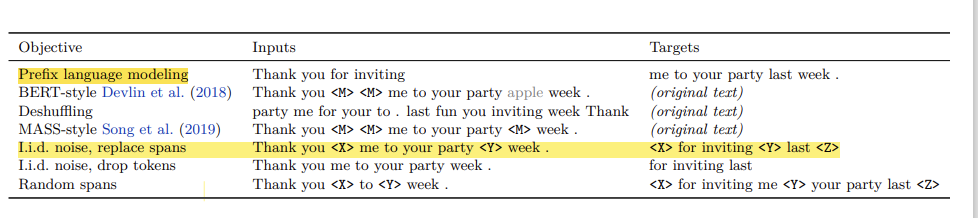

In [ ]:
input_ids = tokenizer('Thank you <extra_id_0> to <extra_id_1> week', return_tensors='pt').input_ids
result = model.generate(input_ids)
print(tokenizer.decode(result[0]))

<extra_id_0> for your time<extra_id_1> the<extra_id_2> for your wonderful<extra_id_3> for your wonderful<extra_id_4> for your time<extra_id_5>


In [ ]:
input_ids = tokenizer('Thank you for inviting', return_tensors='pt').input_ids
result = model.generate(input_ids)
print(tokenizer.decode(result[0]))

Vielen Dank für die Einladung Einladung.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

input_ids = tokenizer("information extration: Beijing is located in China", return_tensors="pt").input_ids
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


Information extration:Beijing is located in China


**T5训练时候的好像采用的是最右侧的结构，x部分是encoder，y部分是language model**

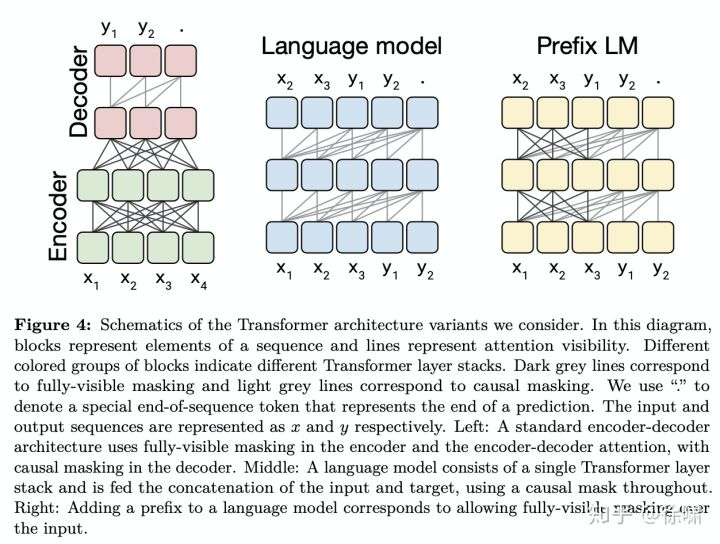

In [ ]:
!pip install transformers==4.19.4

In [ ]:
from transformers import T5Tokenizer, T5Model

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5Model.from_pretrained("t5-small")

input_ids = tokenizer(
    "Studies have been shown that owning a dog is good for you", return_tensors="pt"
).input_ids  # Batch size 1
decoder_input_ids = tokenizer("Studies show that", return_tensors="pt").input_ids  # Batch size 1
print(tokenizer("Studies show that"))
# forward pass
outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
print(outputs.keys())
last_hidden_states = outputs.last_hidden_state
last_hidden_states.shape

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


{'input_ids': [6536, 504, 24, 1], 'attention_mask': [1, 1, 1, 1]}
odict_keys(['last_hidden_state', 'past_key_values', 'encoder_last_hidden_state'])


torch.Size([1, 4, 512])

In [ ]:
import torch
ids=torch.tensor([6536, 504, 24, 1])
outs=tokenizer.convert_ids_to_tokens(ids)
print(outs)

['▁Studies', '▁show', '▁that', '</s>']


## 条件生成

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# training
input_ids = tokenizer("The <extra_id_0> walks in <extra_id_1> park", return_tensors="pt").input_ids
labels = tokenizer("<extra_id_0> cute dog <extra_id_1> the <extra_id_2>", return_tensors="pt").input_ids
outputs = model(input_ids=input_ids, labels=labels)
loss = outputs.loss
logits = outputs.logits
print('loss',loss)
print('logits',logits.shape)
# inference
input_ids = tokenizer(
    "summarize: studies have shown that owning a dog is good for you", return_tensors="pt"
).input_ids  # Batch size 1
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
# studies have shown that owning a dog is good for you.

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


loss tensor(3.7837, grad_fn=<NllLossBackward0>)
logits torch.Size([1, 7, 32128])
studies have shown that owning a dog is good for you.


In [ ]:
logs=logits.argmax(-1)
print(logs)

tensor([[32099,  2447,  2447, 32098,     8, 32097,  2447]])


In [ ]:
logs=logs.squeeze()
outs=tokenizer.convert_ids_to_tokens(logs)
print(outs)

['<extra_id_0>', '▁park', '▁park', '<extra_id_1>', '▁the', '<extra_id_2>', '▁park']


## 试验，能否生成template

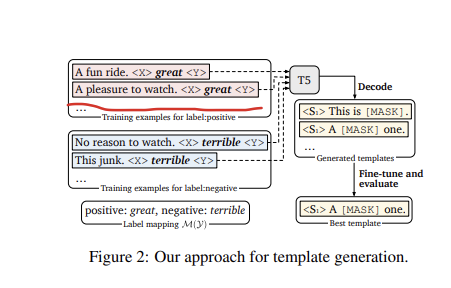

文中，在做实验时，是考虑了在所有的实例，然后找到的output ids，生成了100个模板。还有一些细节，比如最大长度设置。

In [ ]:
#以文中的例子为例：
text=['A fun ride. <extra_id_0> great <extra_id_1>','A pleasure to watch. <extra_id_0> great <extra_id_1>','This junk. <extra_id_0> terrible <extra_id_1>','No reason to watch. <extra_id_0> terrible <extra_id_1>']
input_ids = tokenizer(text, return_tensors='pt',padding=True).input_ids
result = model.generate(input_ids)
print(tokenizer.decode(result[0]))
print(tokenizer.decode(result[1]))
print(tokenizer.decode(result[2]))
print(tokenizer.decode(result[3]))

<pad> <extra_id_0> A<extra_id_1> experience.</s>
<pad> <extra_id_0> A<extra_id_1> watch.</s>
<pad> <extra_id_0> It is<extra_id_1>.</s>
<pad> <extra_id_0> It was<extra_id_1>.</s>


In [ ]:
#以文中的例子为例：
text=['A fun ride. A <extra_id_1> experience.','A pleasure to watch. A <extra_id_1> watch.','This junk. It is <extra_id_1>','No reason to watch.  It was <extra_id_1>.']
input_ids = tokenizer(text, return_tensors='pt',padding=True).input_ids
result = model.generate(input_ids)
print(tokenizer.decode(result[0]))
print(tokenizer.decode(result[1]))
print(tokenizer.decode(result[2]))
print(tokenizer.decode(result[3]))

<pad> A fun ride.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> A pleasure to watch. A pleasure to watch.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <extra_id_0> a great idea.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <extra_id_0> a watch.<extra_id_1> a watch<extra_id_2>.<extra_id_3> a watch<extra_id_4>.<extra_id_5>


In [ ]:
#以文中的例子为例：
text=['A fun ride. It was <extra_id_1>.','A pleasure to watch. It was <extra_id_1>.','This junk. It is <extra_id_1>.','No reason to watch.  It was <extra_id_1>.']
input_ids = tokenizer(text, return_tensors='pt',padding=True).input_ids
result = model.generate(input_ids)
print(tokenizer.decode(result[0]))
print(tokenizer.decode(result[1]))
print(tokenizer.decode(result[2]))
print(tokenizer.decode(result[3]))

<pad> <extra_id_0> a fun ride.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <extra_id_0> a pleasure to watch.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad>.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<pad> <extra_id_0> a watch.<extra_id_1> a watch<extra_id_2>.<extra_id_3> a watch<extra_id_4>.<extra_id_5>


SST数据中随机抽取了两个数据，生成的结果如下。

In [ ]:
text=[
'nothing happens , and it happens to flat characters . It was <extra_id_1>',
'the chocolate factory without charlie .It was <extra_id_1>'      
]
input_ids = tokenizer(text, return_tensors='pt',padding=True).input_ids
result = model.generate(input_ids)
print(tokenizer.decode(result[0]))
print(tokenizer.decode(result[1]))

<pad> <extra_id_0> a good idea.</s> <pad> <pad>
<pad> <extra_id_0> a great place to start.</s>


### 试验能否产生上一个实验的模板

三元组生成

In [ ]:
text=[
"Newspaper ` Explains ' U.S. Interests Section Events FL1402001894 Havana Radio Reloj Network in Spanish 2100 GMT 13 Feb 94. <extra_id_0> Radio Reloj <extra_id_1> Network Havana <extra_id_2> OrgBased_In",
"In 1752 , flagmaker Betsy Ross was born in Philadelphia. <extra_id_0> Betsy Ross <extra_id_1> Philadelphia <extra_id_2> Live_In",
"PURCHASE , N.Y. <extra_id_0> PURCHASE <extra_id_1> N.Y . <extra_id_2> Located_In"
]
input_ids = tokenizer(text, return_tensors='pt',padding=True).input_ids
result = model.generate(input_ids)
print(tokenizer.decode(result[0]))
print(tokenizer.decode(result[1]))
print(tokenizer.decode(result[2]))

<pad> <extra_id_0> Havana<extra_id_1> Network Havana Radio Reloj<extra_id_2> Radio Relo
<pad> <extra_id_0> In 1752, flagmaker<extra_id_1> was born in<extra_id_2>.<extra_id_3> <extra_id_4>.<extra_id_5>
<pad> Located_In</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


实体生成

In [ ]:
text=[
'how many movies has sandler made, sandler <extra_id_0> actor',
'what is the genre for slap shot, slap shot <extra_id_0> title',
'who directed the most horror movies, horror <extra_id_0> genre'
]
input_ids = tokenizer(text, return_tensors='pt',padding=True).input_ids
result = model.generate(input_ids)
print(tokenizer.decode(result[0]))
print(tokenizer.decode(result[1]))
print(tokenizer.decode(result[2]))

<pad> <extra_id_0> is an<extra_id_1>,<extra_id_2> is an<extra_id_3> is an<extra_id_4> is an<extra_id_5> is an<extra_id_6>,
<pad> <extra_id_0>, slap shot, title, title, title, title, title, title,
<pad> <extra_id_0> movies, horror movies, horror movies, horror movies, horror movies, horror movies, horror


In [ ]:
text=[
'Beijing is located in China, The <extra_id_0> is <extra_id_1>'
]
input_ids = tokenizer(text, return_tensors='pt',padding=True).input_ids
result = model.generate(input_ids)
print(tokenizer.decode(result[0]))


<pad> <extra_id_0> city<extra_id_1> located in the city centre.</s>
